# Audio Classification EDA & Clustering Analysis

This notebook explores audio features and performs clustering to identify natural groupings that can distinguish between:
- **Samples**: Short audio clips for music production
- **Stems**: Individual components of songs (vocals, drums, etc.)
- **Songs**: Complete tracks suitable for DJ'ing


In [1]:
# Core imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import logging
import warnings
warnings.filterwarnings('ignore')

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Audio processing
import librosa
import librosa.display

# Database
import sqlite3
from sqlalchemy import create_engine

# Custom modules
import sys
sys.path.append('..')
from feature_extraction import FeatureExtractor, extract_features_batch
from database.db import db_manager
from database.models import File, Metadata, Migration

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries loaded successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


## 1. Data Preparation

First, run the data preparation script to scan, deduplicate, and migrate files:

In [2]:
from prepare_eda_data import prepare_eda_data

# Configuration
SOURCE_DIR = r"D:\OLD OLD Backups\Music\ALL MUSIC"
TARGET_DIR = r"F:\data_test"
RESET_DB = True  # Set to False to keep existing data

# Run data preparation
print(f"Source directory: {SOURCE_DIR}")
print(f"Target directory: {TARGET_DIR}")
print(f"Reset database: {RESET_DB}")
print("\nStarting data preparation...\n")

result = prepare_eda_data(SOURCE_DIR, TARGET_DIR, reset_db=RESET_DB)

print("\n" + "="*60)
print("Data preparation complete!")
print(f"Files scanned: {result['scan_result'].get('files_added', 0)}")
print(f"Files migrated: {result['migration_result'].get('files_copied', 0)}")
print("="*60)

2025-09-05 10:41:20,154 - INFO - ============================================================
2025-09-05 10:41:20,155 - INFO - STARTING EDA DATA PREPARATION
2025-09-05 10:41:20,156 - INFO - Source: D:\OLD OLD Backups\Music\ALL MUSIC
2025-09-05 10:41:20,157 - INFO - Target: F:\data_test
2025-09-05 10:41:20,158 - INFO - ============================================================
2025-09-05 10:41:20,159 - INFO - Resetting database...
2025-09-05 10:41:20,280 - INFO - Database reset complete
2025-09-05 10:41:20,282 - INFO - Database reset complete
2025-09-05 10:41:20,282 - INFO - 
=== PHASE 1: SCANNING ===
2025-09-05 10:41:20,283 - INFO - Estimating file count in D:\OLD OLD Backups\Music\ALL MUSIC...


Source directory: D:\OLD OLD Backups\Music\ALL MUSIC
Target directory: F:\data_test
Reset database: True

Starting data preparation...



2025-09-05 10:41:27,907 - INFO - Found approximately 15326 audio files (23.16 GB)
2025-09-05 10:41:33,780 - INFO - Scan progress: 100/15326
2025-09-05 10:41:40,011 - INFO - Scan progress: 200/15326
2025-09-05 10:41:45,863 - INFO - Scan progress: 300/15326
2025-09-05 10:41:51,225 - INFO - Scan progress: 400/15326
2025-09-05 10:41:56,962 - INFO - Scan progress: 500/15326
2025-09-05 10:42:03,235 - INFO - Scan progress: 600/15326
2025-09-05 10:42:09,682 - INFO - Scan progress: 700/15326
2025-09-05 10:42:13,326 - INFO - Scan progress: 800/15326
2025-09-05 10:42:13,635 - INFO - Scan progress: 900/15326
2025-09-05 10:42:13,911 - INFO - Scan progress: 1000/15326
2025-09-05 10:42:14,212 - INFO - Scan progress: 1100/15326
2025-09-05 10:42:14,493 - INFO - Scan progress: 1200/15326
2025-09-05 10:42:16,648 - INFO - Scan progress: 1300/15326
2025-09-05 10:42:21,679 - INFO - Scan progress: 1400/15326
2025-09-05 10:42:27,306 - INFO - Scan progress: 1500/15326
2025-09-05 10:42:33,338 - INFO - Scan prog


Data preparation complete!
Files scanned: 15326
Files migrated: 0


## 2. Load Data from Database

In [3]:
# Connect to database and load file information
from sqlalchemy.orm import sessionmaker

# Get all migrated files with metadata
with db_manager.get_session() as session:
    # Query for migrated files
    query = session.query(File, Metadata, Migration).join(
        Migration, File.id == Migration.file_id
    ).outerjoin(
        Metadata, File.id == Metadata.file_id
    ).filter(
        Migration.status == 'completed'
    )
    
    results = query.all()
    
    print(f"Found {len(results)} migrated files")
    
    # Convert to structured data
    file_data = []
    for file, metadata, migration in results:
        file_data.append({
            'file_id': file.id,
            'source_path': file.source_path,
            'target_path': migration.target_path,
            'file_size': file.file_size,
            'artist': metadata.artist if metadata else None,
            'title': metadata.title if metadata else None,
            'album': metadata.album if metadata else None,
            'duration_metadata': metadata.duration_seconds if metadata else None,
            'bitrate': metadata.bitrate if metadata else None,
            'sample_rate': metadata.sample_rate if metadata else None,
            'format': metadata.format if metadata else None
        })

df_files = pd.DataFrame(file_data)
print(f"\nDataFrame shape: {df_files.shape}")
print(f"\nFile formats distribution:")
print(df_files['format'].value_counts())
df_files.head()

Found 15180 migrated files

DataFrame shape: (15180, 11)

File formats distribution:
format
wav     12369
mp3      1298
m4a       989
wma        17
flac        1
ogg         1
Name: count, dtype: int64


,file_id,source_path,target_path,file_size,artist,title,album,duration_metadata,bitrate,sample_rate,format
0,1,D:\OLD OLD Backups\Music\ALL MUSIC\mixtape fin...,F:\data_test\Unknown\mixtape finale.wav,347223416,None,mixtape finale,None,984.192857,2822400.0,44100.0,wav
1,2,D:\OLD OLD Backups\Music\ALL MUSIC\MIXTAPE FIN...,F:\data_test\Unknown\MIXTAPE FINISHED draft.mp3,158824,None,MIXTAPE FINISHED draft,None,3.970600,320000.0,44100.0,mp3
2,3,D:\OLD OLD Backups\Music\ALL MUSIC\NEW AMBIENT...,F:\data_test\Snatch DJs\NEW AMBIENT.mp3,18716094,Snatch DJs,NEW AMBIENT,None,467.644075,320000.0,44100.0,mp3
3,4,D:\OLD OLD Backups\Music\ALL MUSIC\Snatch DJs ...,F:\data_test\Snatch DJs\Snatch DJs 5th Syncpho...,35967359,Snatch DJs,Snatch DJs 5th Syncphony mk2,None,898.925700,320000.0,44100.0,mp3
4,5,D:\OLD OLD Backups\Music\ALL MUSIC\Snatch DJs ...,F:\data_test\Snatch DJs\Snatch DJs 5th Syncpho...,35967359,Snatch DJs,Snatch DJs 5th Syncphony,None,898.925700,320000.0,44100.0,mp3


## 3. Feature Extraction

Extract comprehensive audio features for clustering analysis:

In [5]:
# Sample files for analysis (adjust sample size as needed)
SAMPLE_SIZE = min(400, len(df_files))  # Limit to 1000 files for initial analysis
df_sample = df_files.sample(n=SAMPLE_SIZE, random_state=42)

print(f"Extracting features for {SAMPLE_SIZE} files...")

# Prepare metadata dictionary
metadata_dict = {}
for _, row in df_sample.iterrows():
    metadata_dict[row['target_path']] = {
        'artist': row['artist'],
        'title': row['title'],
        'album': row['album'],
        'duration_seconds': row['duration_metadata'],
        'bitrate': row['bitrate'],
        'sample_rate': row['sample_rate'],
        'format': row['format']
    }

# Extract features
file_paths = df_sample['target_path'].tolist()
features_list = extract_features_batch(file_paths, metadata_dict, sr=22050)

# Convert to DataFrame
df_features = pd.DataFrame(features_list)
print(f"\nFeature extraction complete!")
print(f"Features shape: {df_features.shape}")
print(f"Number of features: {df_features.shape[1]}")

# Check for errors
error_count = df_features['error'].notna().sum() if 'error' in df_features.columns else 0
print(f"Files with errors: {error_count}")

# Remove error column if exists
if 'error' in df_features.columns:
    df_features_clean = df_features[df_features['error'].isna()].drop('error', axis=1)
else:
    df_features_clean = df_features

print(f"Clean features shape: {df_features_clean.shape}")

2025-09-05 11:11:57,934 - INFO - Processing file 1/400


Extracting features for 400 files...


2025-09-05 11:12:00,664 - ERROR - Error extracting features from F:\data_test\Explosions In The Sky\01 First Breath After Coma.m4a: 
2025-09-05 11:12:00,666 - ERROR - Error extracting features from F:\data_test\Axwell & Bob Sinclar Feat. Ron Carroll\1-15 What A Wonderful World.m4a: 
2025-09-05 11:12:20,742 - INFO - Processing file 11/400
2025-09-05 11:12:23,094 - ERROR - Error extracting features from F:\data_test\Unknown\._KJ_170_Tight_kit_2bar_Ride_1_8notes.wav: 
2025-09-05 11:12:23,258 - INFO - Processing file 21/400
2025-09-05 11:12:23,830 - ERROR - Error extracting features from F:\data_test\Unknown\._KJ_140_Tight_kit_4bar_loop1.wav: 
2025-09-05 11:12:25,123 - INFO - Processing file 31/400
2025-09-05 11:12:27,437 - ERROR - Error extracting features from F:\data_test\The Ting Tings\1-02 Standing In The Way Of Control.m4a: 
2025-09-05 11:12:27,439 - ERROR - Error extracting features from F:\data_test\ KJ 170 Tight kit 2bar Ride 1\._KJ_170_Tight_kit_2bar_Ride_1-4notes.wav: 
2025-09-0


Feature extraction complete!
Features shape: (400, 116)
Number of features: 116
Files with errors: 44
Clean features shape: (356, 115)


## 4. Feature Analysis & Visualization

In [6]:
# Separate numeric and categorical features
numeric_cols = df_features_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_features_clean.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Remove file_path from numeric columns if it's there
if 'file_path' in categorical_cols:
    categorical_cols.remove('file_path')

# Create feature matrix
X = df_features_clean[numeric_cols].fillna(0).values
print(f"Feature matrix shape: {X.shape}")

Numeric features: 99
Categorical features: 16
Feature matrix shape: (356, 99)


In [7]:
# Key feature distributions
key_features = ['duration_seconds', 'file_size_mb', 'tempo', 'spectral_centroid_mean', 
                'onset_density', 'harmonic_ratio', 'metadata_completeness']

fig = make_subplots(rows=3, cols=3, 
                    subplot_titles=[f for f in key_features if f in numeric_cols][:9])

for i, feature in enumerate([f for f in key_features if f in numeric_cols][:9]):
    row = i // 3 + 1
    col = i % 3 + 1
    
    values = df_features_clean[feature].dropna()
    fig.add_trace(
        go.Histogram(x=values, name=feature, showlegend=False),
        row=row, col=col
    )

fig.update_layout(height=800, title_text="Key Feature Distributions")
fig.show()

In [8]:
# Correlation matrix for key features
key_numeric = [f for f in key_features if f in numeric_cols]
if len(key_numeric) > 0:
    corr_matrix = df_features_clean[key_numeric].corr()
    
    fig = px.imshow(corr_matrix, 
                    labels=dict(color="Correlation"),
                    title="Feature Correlation Matrix",
                    color_continuous_scale='RdBu_r',
                    zmin=-1, zmax=1)
    fig.update_layout(width=800, height=800)
    fig.show()

## 5. Dimensionality Reduction

In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=50)  # Keep top 50 components
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(explained_variance_ratio)+1)),
                         y=explained_variance_ratio,
                         mode='lines+markers',
                         name='Individual'))
fig.add_trace(go.Scatter(x=list(range(1, len(cumulative_variance)+1)),
                         y=cumulative_variance,
                         mode='lines+markers',
                         name='Cumulative'))
fig.update_layout(title='PCA Explained Variance',
                  xaxis_title='Principal Component',
                  yaxis_title='Explained Variance Ratio')
fig.show()

print(f"Variance explained by first 10 components: {cumulative_variance[9]:.2%}")
print(f"Variance explained by first 20 components: {cumulative_variance[19]:.2%}")

Variance explained by first 10 components: 64.39%
Variance explained by first 20 components: 78.34%


In [10]:
# UMAP for visualization
print("Computing UMAP embedding...")
reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_pca[:, :20])  # Use top 20 PCA components

print("UMAP embedding complete!")

Computing UMAP embedding...
UMAP embedding complete!


## 6. Clustering Analysis

In [11]:
# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca[:, :20])
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca[:, :20], kmeans.labels_))

# Plot elbow curve
fig = make_subplots(rows=1, cols=2, subplot_titles=['Elbow Method', 'Silhouette Score'])

fig.add_trace(go.Scatter(x=list(K), y=inertias, mode='lines+markers'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(K), y=silhouette_scores, mode='lines+markers'), row=1, col=2)

fig.update_xaxes(title_text="Number of Clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
fig.update_yaxes(title_text="Inertia", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

fig.update_layout(height=400, title_text="Optimal Number of Clusters")
fig.show()

optimal_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

Optimal number of clusters based on silhouette score: 4


In [12]:
# Apply multiple clustering algorithms
clustering_results = {}

# K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clustering_results['kmeans'] = kmeans.fit_predict(X_pca[:, :20])

# DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
clustering_results['dbscan'] = dbscan.fit_predict(X_pca[:, :20])

# Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
clustering_results['hierarchical'] = hierarchical.fit_predict(X_pca[:, :20])

# Evaluate clustering quality
for name, labels in clustering_results.items():
    if len(set(labels)) > 1:  # Need at least 2 clusters
        silhouette = silhouette_score(X_pca[:, :20], labels)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"{name.upper()}:")
        print(f"  Number of clusters: {n_clusters}")
        print(f"  Silhouette score: {silhouette:.3f}")
        print(f"  Cluster sizes: {pd.Series(labels).value_counts().to_dict()}")
        print()

KMEANS:
  Number of clusters: 4
  Silhouette score: 0.196
  Cluster sizes: {1: 170, 0: 81, 2: 78, 3: 27}

DBSCAN:
  Number of clusters: 1
  Silhouette score: -0.183
  Cluster sizes: {-1: 346, 0: 10}

HIERARCHICAL:
  Number of clusters: 4
  Silhouette score: 0.183
  Cluster sizes: {0: 201, 2: 74, 1: 57, 3: 24}



In [13]:
# Visualize clustering results in 3D
best_clustering = 'kmeans'  # Use K-means as default
labels = clustering_results[best_clustering]

# Add cluster labels to dataframe
df_features_clean['cluster'] = labels

# 3D scatter plot with UMAP
fig = px.scatter_3d(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    z=X_umap[:, 2],
    color=labels.astype(str),
    title=f'3D UMAP Visualization - {best_clustering.upper()} Clustering',
    labels={'color': 'Cluster'},
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(width=900, height=700)
fig.show()

## 7. Cluster Analysis & Interpretation

In [14]:
# Analyze cluster characteristics
feature_importance = ['duration_seconds', 'file_size_mb', 'tempo', 'onset_density',
                     'spectral_centroid_mean', 'harmonic_ratio', 'percussive_ratio',
                     'has_sample_keyword', 'has_stem_keyword', 'has_song_keyword',
                     'metadata_completeness', 'silence_ratio']

# Filter to available features
available_features = [f for f in feature_importance if f in df_features_clean.columns]

# Calculate cluster statistics
cluster_stats = df_features_clean.groupby('cluster')[available_features].agg(['mean', 'std'])

print("Cluster Characteristics (Mean Values):")
print("="*80)

for cluster in sorted(df_features_clean['cluster'].unique()):
    if cluster != -1:  # Skip noise cluster for DBSCAN
        cluster_data = df_features_clean[df_features_clean['cluster'] == cluster]
        print(f"\nCluster {cluster} (n={len(cluster_data)}):")
        print("-" * 40)
        
        for feature in available_features[:7]:  # Show top features
            mean_val = cluster_data[feature].mean()
            std_val = cluster_data[feature].std()
            print(f"  {feature:30s}: {mean_val:10.3f} ± {std_val:.3f}")

Cluster Characteristics (Mean Values):

Cluster 0 (n=81):
----------------------------------------
  duration_seconds              :      7.511 ± 7.524
  file_size_mb                  :      1.504 ± 1.949
  tempo                         :    100.716 ± 68.657
  onset_density                 :      3.965 ± 2.796
  spectral_centroid_mean        :   1629.700 ± 933.313
  harmonic_ratio                :      0.729 ± 0.300
  percussive_ratio              :      0.271 ± 0.300

Cluster 1 (n=170):
----------------------------------------
  duration_seconds              :      2.580 ± 4.915
  file_size_mb                  :      0.362 ± 0.660
  tempo                         :    111.964 ± 60.186
  onset_density                 :      5.478 ± 2.734
  spectral_centroid_mean        :   4081.148 ± 1277.539
  harmonic_ratio                :      0.237 ± 0.243
  percussive_ratio              :      0.763 ± 0.243

Cluster 2 (n=78):
----------------------------------------
  duration_seconds             

In [15]:
# Create radar chart for cluster comparison
from math import pi

# Select features for radar chart
radar_features = ['duration_seconds', 'tempo', 'onset_density', 
                 'spectral_centroid_mean', 'harmonic_ratio']
radar_features = [f for f in radar_features if f in available_features]

if len(radar_features) >= 3:
    # Normalize features for radar chart
    df_normalized = df_features_clean[radar_features + ['cluster']].copy()
    for feature in radar_features:
        df_normalized[feature] = (df_normalized[feature] - df_normalized[feature].min()) / \
                                 (df_normalized[feature].max() - df_normalized[feature].min())
    
    # Calculate mean values per cluster
    cluster_means = df_normalized.groupby('cluster')[radar_features].mean()
    
    # Create radar chart
    fig = go.Figure()
    
    for cluster in cluster_means.index:
        if cluster != -1:
            fig.add_trace(go.Scatterpolar(
                r=cluster_means.loc[cluster].values,
                theta=radar_features,
                fill='toself',
                name=f'Cluster {cluster}'
            ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True, range=[0, 1])
        ),
        showlegend=True,
        title="Cluster Feature Profiles (Normalized)"
    )
    fig.show()

In [16]:
# Sample files from each cluster for manual inspection
print("Sample Files from Each Cluster:")
print("="*80)

for cluster in sorted(df_features_clean['cluster'].unique()):
    if cluster != -1:
        cluster_files = df_features_clean[df_features_clean['cluster'] == cluster]
        print(f"\nCluster {cluster}:")
        print("-" * 40)
        
        # Sample up to 5 files
        samples = cluster_files.sample(n=min(5, len(cluster_files)), random_state=42)
        
        for _, row in samples.iterrows():
            file_path = Path(row['file_path'])
            print(f"  • {file_path.name}")
            print(f"    Duration: {row['duration_seconds']:.1f}s, "
                  f"Size: {row['file_size_mb']:.2f}MB, "
                  f"Tempo: {row['tempo']:.0f} BPM")

Sample Files from Each Cluster:

Cluster 0:
----------------------------------------
  • VEH1 FX - 29.wav
    Duration: 6.2s, Size: 1.04MB, Tempo: 129 BPM
  • Sound 125.wav
    Duration: 18.0s, Size: 4.95MB, Tempo: 152 BPM
  • Sound 89.wav
    Duration: 19.5s, Size: 5.37MB, Tempo: 123 BPM
  • 10 WoodSnareBrushes 09.wav
    Duration: 0.5s, Size: 0.07MB, Tempo: 117 BPM
  • scream.wav
    Duration: 0.6s, Size: 0.08MB, Tempo: 235 BPM

Cluster 1:
----------------------------------------
  • VEH2 Closed Hihats - 044.wav
    Duration: 0.3s, Size: 0.05MB, Tempo: 117 BPM
  • HH6__SEPALOT_.WAV
    Duration: 0.1s, Size: 0.03MB, Tempo: 117 BPM
  • Shaker 12-(D&B).wav
    Duration: 1.2s, Size: 0.10MB, Tempo: 117 BPM
  • 0029A.WAV
    Duration: 6.2s, Size: 0.52MB, Tempo: 161 BPM
  • DC_Kit13_170_Fill.wav
    Duration: 0.5s, Size: 0.08MB, Tempo: 287 BPM

Cluster 2:
----------------------------------------
  • VEH2 Soft Kicks - 031.wav
    Duration: 0.4s, Size: 0.07MB, Tempo: 0 BPM
  • DBD_KICK16.wav


## 8. PyTorch Neural Clustering (Advanced)

In [26]:
# Define a simple autoencoder for feature learning
class AudioAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(AudioAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, encoding_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Prepare data for PyTorch
X_tensor = torch.FloatTensor(X_scaled)
dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AudioAutoencoder(X_scaled.shape[1], encoding_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(f"Model initialized on {device}")
print(f"Input dimension: {X_scaled.shape[1]}")
print(f"Encoding dimension: 16")

Model initialized on cpu
Input dimension: 99
Encoding dimension: 16


Epoch [10/400], Loss: 0.6390
Epoch [20/400], Loss: 0.5420
Epoch [30/400], Loss: 0.5230
Epoch [40/400], Loss: 0.4806
Epoch [50/400], Loss: 0.4554
Epoch [60/400], Loss: 0.4509
Epoch [70/400], Loss: 0.4381
Epoch [80/400], Loss: 0.4482
Epoch [90/400], Loss: 0.4433
Epoch [100/400], Loss: 0.4160
Epoch [110/400], Loss: 0.4067
Epoch [120/400], Loss: 0.4263
Epoch [130/400], Loss: 0.4009
Epoch [140/400], Loss: 0.4046
Epoch [150/400], Loss: 0.4146
Epoch [160/400], Loss: 0.3945
Epoch [170/400], Loss: 0.4006
Epoch [180/400], Loss: 0.3863
Epoch [190/400], Loss: 0.3790
Epoch [200/400], Loss: 0.3718
Epoch [210/400], Loss: 0.3678
Epoch [220/400], Loss: 0.3707
Epoch [230/400], Loss: 0.3613
Epoch [240/400], Loss: 0.3507
Epoch [250/400], Loss: 0.3664
Epoch [260/400], Loss: 0.3568
Epoch [270/400], Loss: 0.3609
Epoch [280/400], Loss: 0.3626
Epoch [290/400], Loss: 0.3533
Epoch [300/400], Loss: 0.3486
Epoch [310/400], Loss: 0.3612
Epoch [320/400], Loss: 0.3619
Epoch [330/400], Loss: 0.3591
Epoch [340/400], Lo

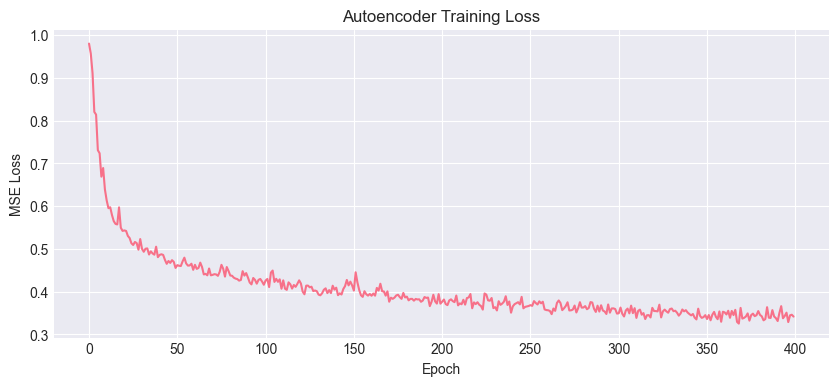

In [27]:
# Train autoencoder
epochs = 400
losses = []

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        x = batch[0].to(device)
        
        # Forward pass
        reconstructed, _ = model(x)
        loss = criterion(reconstructed, x)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [28]:
# Extract learned features
model.eval()
with torch.no_grad():
    X_tensor_device = X_tensor.to(device)
    _, encoded_features = model(X_tensor_device)
    encoded_features = encoded_features.cpu().numpy()

# Cluster on learned features
kmeans_learned = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_learned = kmeans_learned.fit_predict(encoded_features)

# Evaluate
silhouette_learned = silhouette_score(encoded_features, labels_learned)
print(f"Clustering on learned features:")
print(f"  Silhouette score: {silhouette_learned:.3f}")
print(f"  Cluster sizes: {pd.Series(labels_learned).value_counts().to_dict()}")

# Visualize learned features
umap_learned = umap.UMAP(n_components=2, random_state=42)
X_umap_learned = umap_learned.fit_transform(encoded_features)

fig = px.scatter(
    x=X_umap_learned[:, 0],
    y=X_umap_learned[:, 1],
    color=labels_learned.astype(str),
    title='Clustering on Autoencoder-Learned Features',
    labels={'color': 'Cluster'},
    color_discrete_sequence=px.colors.qualitative.Set1
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=800, height=600)
fig.show()

Clustering on learned features:
  Silhouette score: 0.232
  Cluster sizes: {0: 193, 2: 64, 3: 61, 1: 38}


## 9. Classification Rules Discovery

In [29]:
# Analyze what distinguishes clusters
def analyze_cluster_boundaries(df, cluster_col='cluster'):
    """Find the most discriminative features between clusters"""
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.inspection import permutation_importance
    
    # Prepare data
    feature_cols = [col for col in numeric_cols if col in df.columns]
    X = df[feature_cols].fillna(0).values
    y = df[cluster_col].values
    
    # Train decision tree to find rules
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X, y)
    
    # Get feature importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': dt.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return importance, dt

importance, dt = analyze_cluster_boundaries(df_features_clean)

# Display top discriminative features
print("Top 15 Most Discriminative Features:")
print("="*50)
for _, row in importance.head(15).iterrows():
    print(f"{row['feature']:35s}: {row['importance']:.4f}")

# Visualize feature importance
fig = px.bar(importance.head(20), x='importance', y='feature', orientation='h',
             title='Feature Importance for Cluster Discrimination')
fig.update_layout(height=600, yaxis={'categoryorder':'total ascending'})
fig.show()

Top 15 Most Discriminative Features:
zcr_mean                           : 0.3215
chroma_mean                        : 0.2255
signal_std                         : 0.0927
bitrate                            : 0.0779
onset_count                        : 0.0774
duration_seconds                   : 0.0724
mfcc_0_mean                        : 0.0275
mfcc_4_mean                        : 0.0239
spectral_centroid_mean             : 0.0220
tempogram_ratio                    : 0.0193
chroma_9_std                       : 0.0135
mfcc_7_mean                        : 0.0088
chroma_8_mean                      : 0.0088
chroma_0_std                       : 0.0087
file_size_mb                       : 0.0000


In [30]:
# Generate classification rules based on cluster analysis
def generate_classification_rules(df, cluster_labels):
    """Generate simple rules for classification based on cluster characteristics"""
    
    rules = {}
    
    for cluster in sorted(df['cluster'].unique()):
        if cluster != -1:
            cluster_data = df[df['cluster'] == cluster]
            
            # Calculate key statistics
            avg_duration = cluster_data['duration_seconds'].mean()
            avg_size = cluster_data['file_size_mb'].mean()
            avg_tempo = cluster_data['tempo'].mean()
            avg_onset_density = cluster_data['onset_density'].mean()
            
            # Keyword prevalence
            sample_keyword_pct = cluster_data['has_sample_keyword'].mean() * 100
            stem_keyword_pct = cluster_data['has_stem_keyword'].mean() * 100
            song_keyword_pct = cluster_data['has_song_keyword'].mean() * 100
            
            # Determine likely type based on characteristics
            if avg_duration < 30 and avg_size < 5:
                likely_type = "SAMPLE"
            elif avg_duration > 120 and avg_size > 5:
                likely_type = "SONG"
            elif stem_keyword_pct > 30 or (avg_duration > 60 and avg_duration < 300):
                likely_type = "STEM"
            else:
                likely_type = "UNKNOWN"
            
            rules[cluster] = {
                'likely_type': likely_type,
                'avg_duration': avg_duration,
                'avg_size': avg_size,
                'sample_keyword_pct': sample_keyword_pct,
                'stem_keyword_pct': stem_keyword_pct,
                'song_keyword_pct': song_keyword_pct,
                'count': len(cluster_data)
            }
    
    return rules

classification_rules = generate_classification_rules(df_features_clean, labels)

print("\nProposed Classification Rules:")
print("="*80)
for cluster, rule in classification_rules.items():
    print(f"\nCluster {cluster} → {rule['likely_type']} (n={rule['count']})")
    print(f"  Average duration: {rule['avg_duration']:.1f} seconds")
    print(f"  Average size: {rule['avg_size']:.2f} MB")
    print(f"  Has sample keywords: {rule['sample_keyword_pct']:.1f}%")
    print(f"  Has stem keywords: {rule['stem_keyword_pct']:.1f}%")
    print(f"  Has song keywords: {rule['song_keyword_pct']:.1f}%")


Proposed Classification Rules:

Cluster 0 → SAMPLE (n=81)
  Average duration: 7.5 seconds
  Average size: 1.50 MB
  Has sample keywords: 35.8%
  Has stem keywords: 6.2%
  Has song keywords: 0.0%

Cluster 1 → SAMPLE (n=170)
  Average duration: 2.6 seconds
  Average size: 0.36 MB
  Has sample keywords: 47.1%
  Has stem keywords: 0.6%
  Has song keywords: 0.6%

Cluster 2 → SAMPLE (n=78)
  Average duration: 2.0 seconds
  Average size: 0.23 MB
  Has sample keywords: 53.8%
  Has stem keywords: 16.7%
  Has song keywords: 0.0%

Cluster 3 → SONG (n=27)
  Average duration: 289.8 seconds
  Average size: 6.98 MB
  Has sample keywords: 7.4%
  Has stem keywords: 0.0%
  Has song keywords: 18.5%


## 10. Export Results & Recommendations

In [31]:
# Save results
output_dir = Path('eda_results')
output_dir.mkdir(exist_ok=True)

# Save feature matrix with clusters
df_features_clean.to_csv(output_dir / 'features_with_clusters.csv', index=False)
print(f"Saved features to {output_dir / 'features_with_clusters.csv'}")

# Save cluster statistics
cluster_stats_df = pd.DataFrame(classification_rules).T
cluster_stats_df.to_csv(output_dir / 'cluster_statistics.csv')
print(f"Saved cluster statistics to {output_dir / 'cluster_statistics.csv'}")

# Save feature importance
importance.to_csv(output_dir / 'feature_importance.csv', index=False)
print(f"Saved feature importance to {output_dir / 'feature_importance.csv'}")

# Save trained models
torch.save(model.state_dict(), output_dir / 'autoencoder.pth')
print(f"Saved autoencoder model to {output_dir / 'autoencoder.pth'}")

Saved features to eda_results\features_with_clusters.csv
Saved cluster statistics to eda_results\cluster_statistics.csv
Saved feature importance to eda_results\feature_importance.csv
Saved autoencoder model to eda_results\autoencoder.pth


In [32]:
# Generate final recommendations
print("\n" + "="*80)
print("CLASSIFICATION SYSTEM RECOMMENDATIONS")
print("="*80)

print("\n1. PRIMARY CLASSIFICATION FEATURES (by importance):")
for i, (_, row) in enumerate(importance.head(10).iterrows(), 1):
    print(f"   {i:2d}. {row['feature']} (importance: {row['importance']:.3f})")

print("\n2. SUGGESTED CLASSIFICATION THRESHOLDS:")
print("   • SAMPLES: duration < 30s AND file_size < 5MB")
print("   • SONGS: duration > 120s AND file_size > 5MB")
print("   • STEMS: 30s < duration < 300s OR has_stem_keyword")

print("\n3. CLUSTERING INSIGHTS:")
print(f"   • Optimal number of clusters: {optimal_k}")
print(f"   • Best clustering method: K-Means")
print(f"   • Silhouette score: {silhouette_scores[optimal_k-2]:.3f}")

print("\n4. NEXT STEPS:")
print("   • Manually verify cluster labels with sample files")
print("   • Implement rule-based classifier using discovered thresholds")
print("   • Train supervised model using verified labels")
print("   • Consider ensemble approach combining rules and ML")

print("\n" + "="*80)


CLASSIFICATION SYSTEM RECOMMENDATIONS

1. PRIMARY CLASSIFICATION FEATURES (by importance):
    1. zcr_mean (importance: 0.322)
    2. chroma_mean (importance: 0.226)
    3. signal_std (importance: 0.093)
    4. bitrate (importance: 0.078)
    5. onset_count (importance: 0.077)
    6. duration_seconds (importance: 0.072)
    7. mfcc_0_mean (importance: 0.028)
    8. mfcc_4_mean (importance: 0.024)
    9. spectral_centroid_mean (importance: 0.022)
   10. tempogram_ratio (importance: 0.019)

2. SUGGESTED CLASSIFICATION THRESHOLDS:
   • SAMPLES: duration < 30s AND file_size < 5MB
   • SONGS: duration > 120s AND file_size > 5MB
   • STEMS: 30s < duration < 300s OR has_stem_keyword

3. CLUSTERING INSIGHTS:
   • Optimal number of clusters: 4
   • Best clustering method: K-Means
   • Silhouette score: 0.196

4. NEXT STEPS:
   • Manually verify cluster labels with sample files
   • Implement rule-based classifier using discovered thresholds
   • Train supervised model using verified labels
   